# " Keep it Simple Stupid!"
# " Don't Repeat Yourself!"

# Writing a good function:
  
       -Sensibly named
      -Has a single responsibility
      -Includes a docstring
      -Returns a value
      -Is not longer than 50 lines
      -Is idempotent and, if possible , pure
  

In [ ]:
import this

In [26]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as Makecopy

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib nbagg
%matplotlib inline
np.random.seed(1)
plt.style.use('seaborn-dark')

In [2]:
# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.
    
    return m, b, lnf




def log_plus(x,y):
    '''Return the addition of x + y in log-space'''
    
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [3]:
# truth
m_true = 2
b_true = 4.294


# generate mock data
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.02*np.random.rand(N)
y_true = m_true * x 
y = y_true + np.abs(f_true * y_true) * np.random.randn(N)
y += yerr * np.random.randn(N)

# plot results
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
#plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel('X')
plt.ylabel('Y')

NameError: name 'f_true' is not defined

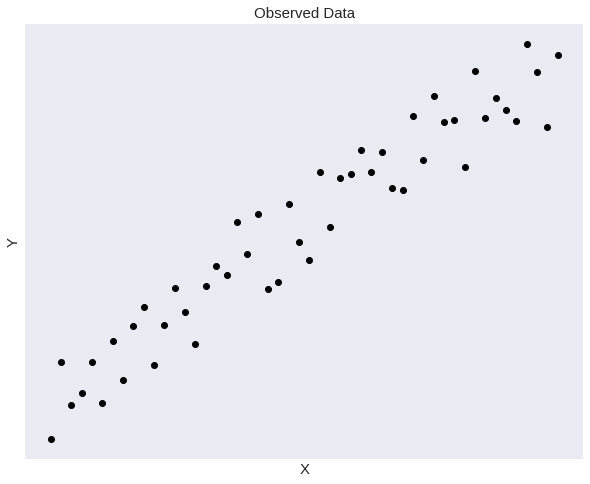

In [28]:
x = np.linspace(0,20)
y_err = np.random.uniform(-15,5, size=(len(x)))
y = 3*x + y_err


# plot results
plt.figure(figsize=(10, 8))
plt.plot(x, y,'o',c='k')
#plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel('X',fontsize=15)
plt.ylabel('Y',fontsize=15)
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.title('Observed Data',fontsize=15)
plt.savefig('Observed_Data.png')


In [20]:
plt.plot?

In [5]:
# Number of live points
num_of_live_points = 200

#Number of dimensions
ndim = 3

#Save objects
points = np.zeros((num_of_live_points,ndim))

#log_likelihood of live objects
log_like_of_live_points = np.zeros((num_of_live_points))


#Generate Live objects
for i in range(num_of_live_points):
    points[i,:] = prior_transform(utheta=np.random.uniform(0,1.0,size=ndim))
    #model = Model_function(params=points[i,:],x=x_values)
    log_like_of_live_points[i] = loglike(points[i,:])
    
    #Log_Likelihood(data=y_values,sigma=error_values,model=model)


In [ ]:
nest = 10000
keep = np.zeros((nest,ndim))  #store bad points
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e200     # SUM(weights)= Z Evidence
H = 0


In [ ]:
# Defined intervals for each parameters
Flat_interval = [(-15,15),(-15,15),(-15,15)]
mcmc_steps = 100
Acceptance = np.empty((nest))

In [ ]:
#Progress bar report
progressor = IntProgress(
    value=0,
    min=0,
    max=nest,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor)
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / num_of_live_points))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(log_like_of_live_points)
    
    #Save worst opbject
    keep[i,:] = points[worst,:]
    logl_sample.append(log_like_of_live_points[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + log_like_of_live_points[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = log_plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*log_like_of_live_points[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/num_of_live_points
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(points))
        if (copy != worst):break
            
    points[worst,:] = Makecopy.deepcopy(points[copy,:])
    log_Likelihood_old =  log_like_of_live_points[copy]
    
    theta = points[copy,:]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (ndim,)
    
   # initialize mcmc params
    
    scale = 1.0
    accept = 0
    reject = 0
    for mcmci in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        propose_step = np.random.normal(0,scale=scale,size=ndim)
        new_point = theta + propose_step
        
        
        add = 0
        for j in range(len(theta)):
                if Flat_interval[j][0] <= new_point[j] <= Flat_interval[j][1]:
                    add += 1
                else:
                    pass

        if add == len(theta):
            Prior = 1
        else:
            Prior = 0
        
        #Calculate Log_likelihood of new point
        #model = Model_function(params=new_point,x=x_values)
        
        #Ignore divde by zero runtimewarining
        np.seterr(divide='ignore')
        log_Likelihood_new = loglike(new_point) + np.log(Prior)
        #Log_Likelihood(data=y_values,sigma=1,model=model)
       
    
        #Acceptance ratio alpha
        alpha = np.exp(log_Likelihood_new-log_Likelihood_old)
        
        
        if alpha>=1:
            points[worst,:] = new_point  #Replace worst point with new point
            log_like_of_live_points[worst] = log_Likelihood_new   #Replace the worst likelihood with new one  
            accept += 1
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                points[worst,:] = new_point 
                log_like_of_live_points[worst] = log_Likelihood_new
                accept += 1
                
            else:
                theta = theta
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    Acceptance_Ratio = accept/(accept+reject)
    Acceptance[i] =  Acceptance_Ratio
    
    progressor.value += 1
    
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/num_of_live_points)
H = H        #np.exp(H)/np.log(2.)
#print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,len(Acceptance)),Acceptance,'+')
plt.ylabel('Acceptance Ratio')
plt.axhline(0.2,c='blue')

In [ ]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))
print('Effective Sample Size : {}'.format(effective_sample_size))

#Progress bar
progressor_samples = IntProgress(
    value=0,
    min=0,
    max=effective_sample_size,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor_samples)

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)

    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        
        S += 1
        progressor_samples.value += 1
    if S >= effective_sample_size:
        break


In [ ]:
plt.figure(figsize=(15,10))

labels = ['m','b','lnf']
for i in range(ndim):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],histtype="step")
    plt.xlabel(labels[i])
    

In [ ]:
a,b,c= np.mean(sample[:,0]),np.mean(sample[:,1]),np.mean(sample[:,2])

astd,bstd,cstd = np.std(sample[:,0]),np.std(sample[:,1]),np.std(sample[:,2])


In [ ]:
a,b,c

In [ ]:
astd,bstd,cstd

In [ ]:
import corner


In [ ]:
plt.figure(figsize=(15,8))
corner.corner(sample,labels=['m','b','lnf'],show_titles=True,bins=20);

In [ ]:
y_mod = a * x + b

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(x, y_mod, color='blue', lw=3)
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
plt.xlabel('X')
plt.ylabel('Y')